<a href="https://colab.research.google.com/github/daniyal9538/CID/blob/master/Data_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Install all dependencies

In [1]:
!pip3 install https://github.com/OlafenwaMoses/ImageAI/releases/download/2.0.2/imageai-2.0.2-py3-none-any.whl

     |████████████████████████████████| 153kB 612kB/s 


#Get all data

In [0]:
# Authenticate to GCS.
from google.colab import auth
auth.authenticate_user()

# https://cloud.google.com/resource-manager/docs/creating-managing-projects
project_id = 'test-demo-222423'
bucket_name = 'cid_training_data'
# Create the service client.
from googleapiclient.discovery import build
gcs_service = build('storage', 'v1')



In [3]:
data=[]
from apiclient.http import MediaIoBaseDownload
for i in range (3, 5):
  try: 
      download_name = "demo-data-{}.npy".format(i)
      path_name = "demo-data/demo-data-{}.npy".format(i)

      with open(download_name, 'wb') as f:
        # Download the file from a given Google Cloud Storage bucket.
        request = gcs_service.objects().get_media(bucket=bucket_name,
                                                  object=path_name)
        media = MediaIoBaseDownload(f, request)

        done = False
        while not done:
          # _ is a placeholder for a progress object that we ignore.
          # (Our file is small, so we skip reporting progress.)
          _, done = media.next_chunk()        
     
      print('Download complete ', download_name)
  except Exception as ex:
    print('Download failed', download_name, ex)

Download complete  demo-data-3.npy
Download complete  demo-data-4.npy


In [4]:
try: 
  download_name = "camera_matrix_480.pkl"
  path_name = "demo-data/camera_matrix_480.pkl"

  with open(download_name, 'wb') as f:
        # Download the file from a given Google Cloud Storage bucket.
    request = gcs_service.objects().get_media(bucket=bucket_name,
                                                  object=path_name)
    media = MediaIoBaseDownload(f, request)

    done = False
    while not done:
          # _ is a placeholder for a progress object that we ignore.
          # (Our file is small, so we skip reporting progress.)
      _, done = media.next_chunk()        
    
    print('Download complete ', download_name)
except Exception as ex:
  print('Download failed', download_name, ex)
    
try: 
  download_name = "object_and_image_points_480.pkl"
  path_name = "demo-data/object_and_image_points_480.pkl"

  with open(download_name, 'wb') as f:
        # Download the file from a given Google Cloud Storage bucket.
    request = gcs_service.objects().get_media(bucket=bucket_name,
                                                  object=path_name)
    media = MediaIoBaseDownload(f, request)

    done = False
    while not done:
          # _ is a placeholder for a progress object that we ignore.
          # (Our file is small, so we skip reporting progress.)
      _, done = media.next_chunk()        
     
    print('Download complete ', download_name)
except Exception as ex:
  print('Download failed', download_name, ex)
    
try: 
  download_name = "yolo-tiny.h5"
  path_name = "demo-data/yolo-tiny.h5"

  with open(download_name, 'wb') as f:
        # Download the file from a given Google Cloud Storage bucket.
    request = gcs_service.objects().get_media(bucket=bucket_name,
                                                  object=path_name)
    media = MediaIoBaseDownload(f, request)

    done = False
    while not done:
          # _ is a placeholder for a progress object that we ignore.
          # (Our file is small, so we skip reporting progress.)
      _, done = media.next_chunk()        
     
    print('Download complete ', download_name)
except Exception as ex:
  print('Download failed', download_name, ex)    

Download complete  camera_matrix_480.pkl
Download complete  object_and_image_points_480.pkl
Download complete  yolo-tiny.h5


In [5]:
from imageai.Detection import ObjectDetection
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
from IPython.display import clear_output as co
import pickle
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from shapely.geometry import Polygon
import shapely

from shapely import affinity

Using TensorFlow backend.


#Initiate Pipeline parameters

In [0]:
execution_path = os.getcwd()
tinyYolo="yolo-tiny.h5"
detector = ObjectDetection()
detector.setModelTypeAsTinyYOLOv3()
detector.setModelPath( os.path.join(execution_path , tinyYolo))
detector.loadModel(detection_speed="normal")
points_pickle = pickle.load( open( "object_and_image_points_480.pkl", "rb" ) )
chess_points = points_pickle["chesspoints"]
image_points = points_pickle["imagepoints"]
img_size = points_pickle["imagesize"]
# load camera matrix and distortion matrix
camera = pickle.load(open( "camera_matrix_480.pkl", "rb" ))
mtx = camera['mtx']
dist = camera['dist']
camera_img_size = camera['imagesize']

#Pipeline

##Lane pipeline

In [0]:
def distort_correct(img,mtx,dist,camera_img_size):
    img_size1 = (img.shape[1],img.shape[0])
    #print(img_size1)
    #print(camera_img_size)
    assert (img_size1 == camera_img_size),'image size is not compatible'
    undist = cv.undistort(img, mtx, dist, None, mtx)
    return undist

def abs_sobel_thresh(img, orient='x', thresh=(0,255)):
    # Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    # Return the result
    return binary_output

def mag_threshold(img, sobel_kernel=3, thresh=(0, 255)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel)
    y = cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the xy magnitude 
    mag = np.sqrt(x**2 + y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale = np.max(mag)/255
    eightbit = (mag/scale).astype(np.uint8)
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(eightbit)
    binary_output[(eightbit > thresh[0]) & (eightbit < thresh[1])] =1 
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # 1) Convert to grayscale
    gray = cv.cvtColor(img, cv.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    x = np.absolute(cv.Sobel(gray, cv.CV_64F, 1, 0, ksize=sobel_kernel))
    y = np.absolute(cv.Sobel(gray, cv.CV_64F, 0, 1, ksize=sobel_kernel))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    direction = np.arctan2(y, x)
    binary_output = np.zeros_like(direction)
    binary_output[(direction > thresh[0]) & (direction < thresh[1])] = 1
    return binary_output

def hls_select(img, sthresh=(0, 255),lthresh=()):
    # 1) Convert to HLS color space
    hls_img = cv.cvtColor(img, cv.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    L = hls_img[:,:,1]
    S = hls_img[:,:,2]
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S >= sthresh[0]) & (S <= sthresh[1])
                 & (L > lthresh[0]) & (L <= lthresh[1])] = 1
    return binary_output

def red_select(img, thresh=(0, 255)):
    # Apply a threshold to the R channel
    R = img[:,:,0]
    # Return a binary image of threshold result
    binary_output = np.zeros_like(R)
    binary_output[(R > thresh[0]) & (R <= thresh[1])] = 1
    return binary_outputa

def binary_pipeline(img):
    
    img_copy = cv.GaussianBlur(img, (3, 3), 0)
    #img_copy = np.copy(img)
    
    # color channels
    s_binary = hls_select(img_copy, sthresh=(140, 255), lthresh=(120, 255))
    #red_binary = red_select(img_copy, thresh=(200,255))
    
    # Sobel x
    x_binary = abs_sobel_thresh(img_copy,thresh=(25, 200))
    y_binary = abs_sobel_thresh(img_copy,thresh=(25, 200), orient='y')
    xy = cv.bitwise_and(x_binary, y_binary)
    
    #magnitude & direction
    mag_binary = mag_threshold(img_copy, sobel_kernel=3, thresh=(30,100))
    dir_binary = dir_threshold(img_copy, sobel_kernel=3, thresh=(0.8, 1.2))
    
    # Stack each channel
    gradient = np.zeros_like(s_binary)
    gradient[((x_binary == 1) & (y_binary == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    final_binary = cv.bitwise_or(s_binary, gradient)
    
    return final_binary

def warp_image(img):
    global pt 
    image_size = (img.shape[1], img.shape[0])
    x = img.shape[1]
    y = img.shape[0]

    #the "order" of points in the polygon you are defining does not matter
    #but they need to match the corresponding points in destination_points!
    source_points = np.float32([
    [0.117 * x, y],
    [(0.5 * x) - (x*0.078), (2/3)*y],
    [(0.5 * x) + (x*0.078), (2/3)*y],
    [x - (0.117 * x), y]
    ])

#     #chicago footage
#     source_points = np.float32([
#                 [300, 720],
#                 [500, 600],
#                 [700, 600],
#                 [850, 720]
#                 ])
    
#     destination_points = np.float32([
#                 [200, 720],
#                 [200, 200],
#                 [1000, 200],
#                 [1000, 720]
#                 ])
    
    destination_points = np.float32([
    [0.25 * x, y],
    [0.25 * x, 0],
    [x - (0.25 * x), 0],
    [x - (0.25 * x), y]
    ])
    
    perspective_transform = cv.getPerspectiveTransform(source_points, destination_points)
    inverse_perspective_transform = cv.getPerspectiveTransform( destination_points, source_points)
    pt = perspective_transform
    warped_img = cv.warpPerspective(img, perspective_transform, image_size, flags=cv.INTER_LINEAR)
    
    #print(source_points)
    #print(destination_points)
    
    return warped_img, inverse_perspective_transform

def track_lanes_initialize(binary_warped):
    
    global window_search
    
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    # we need max for each half of the histogram. the example above shows how
    # things could be complicated if didn't split the image in half 
    # before taking the top 2 maxes
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    # this will throw an error in the height if it doesn't evenly divide the img height
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(binary_warped.shape[0] - (window+1)*window_height)
        win_y_high = int(binary_warped.shape[0] - window*window_height)
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 3) 
        cv.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 3) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

            
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit,right_fit

def track_lanes_update(binary_warped, left_fit,right_fit):

    global window_search
    global frame_count
    
    # repeat window search to maintain stability
    if frame_count % 10 == 0:
        window_search=True
   
        
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]


    return left_fit,right_fit,leftx,lefty,rightx,righty

# A function to get quadratic polynomial output
def get_val(y,poly_coeff):
    return poly_coeff[0]*y**2+poly_coeff[1]*y+poly_coeff[2]

def lane_fill_poly(binary_warped,undist,left_fit,right_fit, inverse_perspective_transform):
    global ipt

    # Generate x and y values
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = get_val(ploty,left_fit)
    right_fitx = get_val(ploty,right_fit)
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast x and y for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane 
    lane_poly = cv.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    polypts = pts
    ipt = inverse_perspective_transform
    # Warp using inverse perspective transform
    newwarp = cv.warpPerspective(color_warp, inverse_perspective_transform, (binary_warped.shape[1], binary_warped.shape[0])) 
    # overlay
    #newwarp = cv.cvtColor(newwarp, cv.COLOR_BGR2RGB)
    result = cv.addWeighted(undist, 1, newwarp, 0.3, 0)
        
    return result, polypts, lane_poly

def measure_curve(binary_warped,left_fit,right_fit):
        
    # generate y values 
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # measure radius at the maximum y value, or bottom of the image
    # this is closest to the car 
    y_eval = np.max(ploty)
    
    # coversion rates for pixels to metric
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
   
    # x positions lanes
    leftx = get_val(ploty,left_fit)
    rightx = get_val(ploty,right_fit)

    # fit polynomials in metric 
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # calculate radii in metric from radius of curvature formula
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # averaged radius of curvature of left and right in real world space
    # should represent approximately the center of the road
    curve_rad = round((left_curverad + right_curverad)/2)
    
    return curve_rad

def vehicle_offset(img,left_fit,right_fit):
    
    # THIS RATE CAN CHANGE GIVEN THE RESOLUTION OF THE CAMERA!!!!!
    # BE SURE TO CHANGE THIS IF USING DIFFERENT SIZE IMAGES!!!
    xm_per_pix = 3.7/700 
    image_center = img.shape[1]/2
    
    ## find where lines hit the bottom of the image, closest to the car
    left_low = get_val(img.shape[0],left_fit)
    right_low = get_val(img.shape[0],right_fit)
    
    # pixel coordinate for center of lane
    lane_center = (left_low+right_low)/2.0
    
    ## vehicle offset
    distance = image_center - lane_center
    
    ## convert to metric
    return (round(distance*xm_per_pix,5))

def lane_pipeline(img):
    
    global window_search
    global left_fit_prev
    global right_fit_prev
    global frame_count
    global curve_radius
    global offset
        
    # load camera matrix and distortion matrix
    camera = pickle.load(open( "camera_matrix_480.pkl", "rb" ))
    mtx = camera['mtx']
    dist = camera['dist']
    camera_img_size = camera['imagesize']
    
    #correct lens distortion
    undist = distort_correct(img,mtx,dist,camera_img_size)
    # get binary image
    binary_img = binary_pipeline(undist)
    #perspective transform
    birdseye, inverse_perspective_transform = warp_image(binary_img)
    
    if window_search:
        #window_search = False
        #window search
        left_fit,right_fit = track_lanes_initialize(birdseye)
        #store values
        left_fit_prev = left_fit
        right_fit_prev = right_fit
        
    else:
        #load values
        left_fit = left_fit_prev
        right_fit = right_fit_prev
        #search in margin of polynomials
        left_fit,right_fit,leftx,lefty,rightx,righty = track_lanes_update(birdseye, left_fit,right_fit)
    
    #save values
    left_fit_prev = left_fit
    right_fit_prev = right_fit
    
    #draw polygon
    processed_frame, pts, lane_poly = lane_fill_poly(birdseye, undist, left_fit, right_fit, inverse_perspective_transform)
    
    #update ~twice per second
    if frame_count==0 or frame_count%15==0:
        #measure radii
        curve_radius = measure_curve(birdseye,left_fit,right_fit)
        #measure offset
        offset = vehicle_offset(undist, left_fit, right_fit)
    
        
    #printing information to frame
    font = cv.FONT_HERSHEY_TRIPLEX
    #processed_frame = cv.putText(processed_frame, 'Radius: '+str(curve_radius)+' m', (30, 40), font, 1, (0,255,0), 2)
    #processed_frame = cv.putText(processed_frame, 'Offset: '+str(offset)+' m', (30, 80), font, 1, (0,255,0), 2)
   
    frame_count += 1
    #processed_frame = cv.resize(processed_frame, (480,270))
    return processed_frame, pts, lane_poly

##Helper functions

In [0]:
import json

class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, (np.int_, np.intc, np.intp, np.int8,
            np.int16, np.int32, np.int64, np.uint8,
            np.uint16, np.uint32, np.uint64)):
            return int(obj)
        elif isinstance(obj, (np.float_, np.float16, np.float32, 
            np.float64)):
            return float(obj)
        elif isinstance(obj,(np.ndarray,)): #### This is the fix
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)

def dunmpToJson(frame_dict, name):
  with open(name+'.json', "w") as write_file:
    json.dump(frame_dict, write_file, indent=4, cls=NumpyEncoder)

In [0]:
def downsampleX(coord):
    return int(np.floor((coord/1280)*480))

def downsampleY(coord):
    return int(np.floor((coord/720)*270))
  
def downsamplePts(pts):
    ptArr = []
    for i in pts[0][0]:
        ptx = downsampleX(i[0])
        pty = downsampleY(i[1])
        ptArr.append([ptx, pty])
    return (np.array([ptArr]))  
  
def getLanePolygon(pts):
  polygon = []
  for i in pts[0]:
    pt = np.array([[[i[0], i[1]]]], dtype = np.float32)
    newpts = cv.perspectiveTransform(pt, ipt)
    x = newpts[0][0][0]
    y=newpts[0][0][1]
    polygon.append([x,y])
  polygon = np.array([polygon], dtype=np.int64)
  return polygon

def isInLane(x1, y1, x2, y2, lp):
  shape = []
  for i in reversed(lp[0]):
    x = i[0]
    y = i[1]
    temp = (x, y)
    shape.append(temp)
  poly = Polygon(shape)
  poly = affinity.rotate(poly, 180)
  box = Polygon([(x1,y1), (x2, y1), (x2, y2), (x1,y2)])
  center = box.centroid
  return (poly.contains(center))

def processDetections(det, lp):#detections, lanePolygon
  #box_points in the form x1, y1, x2, y2
  for i in det:
    x1 = i['box_points'][0]
    y1 = i['box_points'][1]
    x2 = i['box_points'][2]
    y2 = i['box_points'][3]
    inLane = isInLane(x1, y1, x2, y2, lp)
    i['inLane'] = inLane
    i['midX'] = int((x1+x2)/2)
    i['midY'] = int((y1+y2/2))
    box = Polygon([(x1,y1), (x2, y1), (x2, y2), (x1,y2)])
    area = box.area
    i['box_area'] = area
  return det
  

##Full pipeline

In [0]:
def pipeline(img):
  global window_search
  global frame_count
  window_search=True
  frame_count = 15
  detected, detections = detector.detectObjectsFromImage(input_image=img, input_type = 'array', output_type='array', minimum_percentage_probability=30)
  lane_img, pts, lane_poly = lane_pipeline(img)
  lanePolygon = getLanePolygon(pts)
  frame_dict ={}
  
  #print(pts)
  #print(detections)
  #box_points in the form x1, y1, x2, y2  
  detections = processDetections(detections, lanePolygon)
  frame_dict['objects']=detections
  frame_dict['num_of_objects']=len(detections)
  frame_dict['lanePolygon'] = lanePolygon
  
  #get lanepoly area
  shape = []
  for i in reversed(lanePolygon[0]):
    x = i[0]
    y = i[1]
    temp = (x, y)
    shape.append(temp)
  poly = Polygon(shape)
  area = poly.area
  frame_dict['lanePolygon_area'] = area
  
  return detected, frame_dict, lane_img, lane_poly

#Call pipeline

In [0]:
data = np.load('demo-data-3.npy', allow_pickle=True)

In [0]:
frame_dict = []
ODFrames = []
laneFrames = []
lanePolys = []
data1 = data[980:999]
global window_search
global frame_count
for i in data1:
  ODFrame, Object, laneFrame, lanePoly = pipeline(i[0])
  frame_dict.append(Object)
  ODFrames.append(ODFrame)
  laneFrames.append(laneFrame)
  lanePolys.append(lanePoly)

In [0]:
dunmpToJson(frame_dict, 'data')

#Ongoing work


In [0]:
num=10

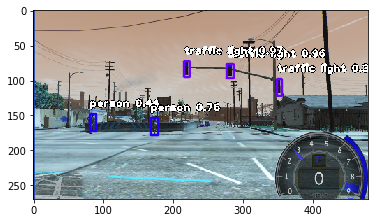

In [91]:
plt.imshow(ODFrames[num])

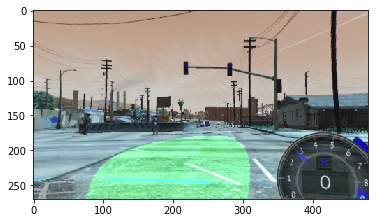

In [92]:
plt.imshow(laneFrames[num])

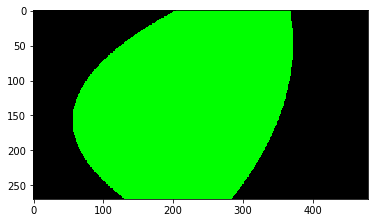

In [76]:

plt.imshow(lanePolys[num])

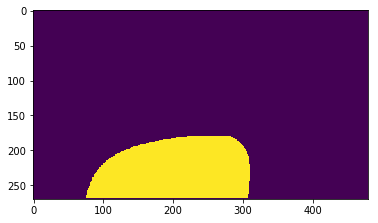

In [83]:
lp =frame_dict[num]['lanePolygon']
t = np.zeros((270, 480))
plt.imshow(cv2.fillPoly(t, [lp], (255 ,0, 255)))

In [0]:

for i in reversed(lp[0]):
    x = i[0]
    y = i[1]
    temp = (x, y)
    shape.append(temp)
poly = Polygon(shape)
poly = affinity.rotate(poly, 180)
poly

In [0]:
while(True):
  pass